In [144]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [132]:
BATCH_SIZE = 512
# N_WORKERS = cpu_count() - 1
N_WORKERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 10
LR_G = 1e-4
LR_D = 1e-4
WEIGHT_DECAY = 1e-4

CONFIG = Config()

In [145]:
train_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='train')
val_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='val')
test_dataset = TextArtDataLoader('united', CONFIG.WORD2VEC_MODEL_FILE, mode='test')
train_align_collate = AlignCollate('train',
                                   CONFIG.WORD2VEC_MODEL_FILE,
                                   CONFIG.MEAN,
                                   CONFIG.STD,
                                   CONFIG.IMAGE_SIZE_HEIGHT,
                                   CONFIG.IMAGE_SIZE_WIDTH,
                                   horizontal_flipping=CONFIG.HORIZONTAL_FLIPPING,
                                   random_rotation=CONFIG.RANDOM_ROTATION,
                                   color_jittering=CONFIG.COLOR_JITTERING,
                                   random_grayscale=CONFIG.RANDOM_GRAYSCALE,
                                   random_channel_swapping=CONFIG.RANDOM_CHANNEL_SWAPPING,
                                   random_gamma=CONFIG.RANDOM_GAMMA,
                                   random_resolution=CONFIG.RANDOM_RESOLUTION,
                                   word_vectors_similar_pad=CONFIG.WORD_VECTORS_SIMILAR_PAD,
                                   word_vectors_similar_pad_topN=CONFIG.WORD_VECTORS_SIMILAR_PAD_TOPN)
val_align_collate = AlignCollate('val',
                                 CONFIG.WORD2VEC_MODEL_FILE,
                                 CONFIG.MEAN,
                                 CONFIG.STD,
                                 CONFIG.IMAGE_SIZE_HEIGHT,
                                 CONFIG.IMAGE_SIZE_WIDTH,
                                 horizontal_flipping=CONFIG.HORIZONTAL_FLIPPING,
                                 random_rotation=CONFIG.RANDOM_ROTATION,
                                 color_jittering=CONFIG.COLOR_JITTERING,
                                 random_grayscale=CONFIG.RANDOM_GRAYSCALE,
                                 random_channel_swapping=CONFIG.RANDOM_CHANNEL_SWAPPING,
                                 random_gamma=CONFIG.RANDOM_GAMMA,
                                 random_resolution=CONFIG.RANDOM_RESOLUTION,
                                 word_vectors_similar_pad=CONFIG.WORD_VECTORS_SIMILAR_PAD,
                                 word_vectors_similar_pad_topN=CONFIG.WORD_VECTORS_SIMILAR_PAD_TOPN)

batch_sampler = ImageBatchSampler('united', BATCH_SIZE, shuffle_groups=True)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
                          sampler=batch_sampler,
                         )
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=val_align_collate,
                         )
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=N_WORKERS,
                          pin_memory=True,
                          collate_fn=None,
                         )

IMAGE: torch.Size([16, 3, 64, 64])
WV: torch.Size([16, 7, 2000])
genre,painting,orphism,sport,regionalism,festival,group,
landscape,cubism,rock,newspaper,port,finland,life,
portrait,expressionism,fauvism,male,albrecht,kustodiev,buchar,
genre,painting,post,impressionism,handwork,painting,quadratura,
f2u,deco,ftu,divider,mint,teal,page,
portrait,baroque,male,konstantin,serebriakova,pugachev,picasso,
aesthetic,f2u,candy,divider,decorative,aid,ftu,
caricature,realism,male,neoclassicism,caricature,nuenen,romanticism,
brown,green,design,art,nouveau,modern,female,
flower,painting,post,impressionism,plants,wash,cloisonnism,
russian,federation,genre,painting,realism,realism,baroque,
armenia,design,expressionism,scene,design,richard,igor,
stamp,lgbtqia,lgbt,rule,prejudice,health,community,
undertale,gaster,chara,route,fell,toriel,shatter,
landscape,realism,auvergne,limousin,morozova,creuse,neoclassicism,
genre,painting,pop,art,zamyatin,ziegfeld,mikado,


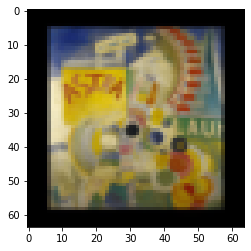

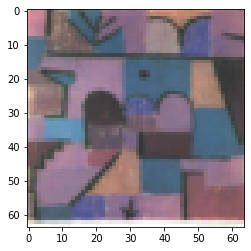

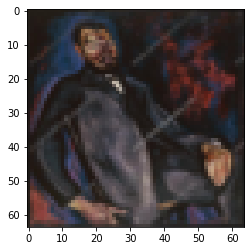

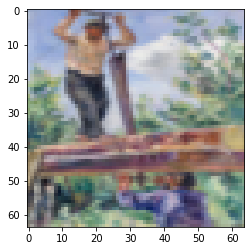

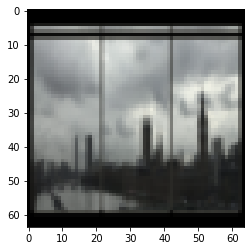

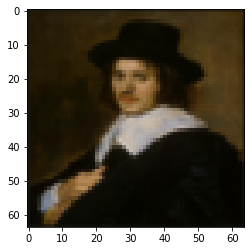

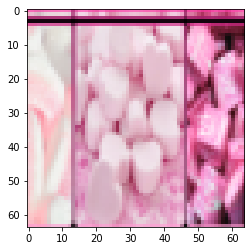

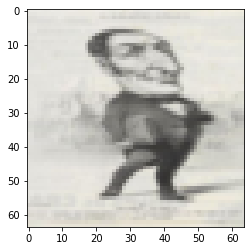

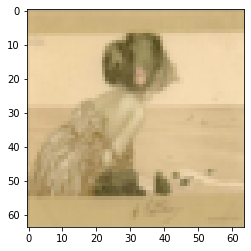

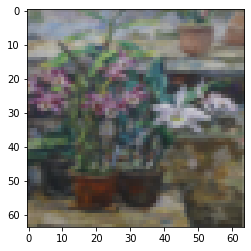

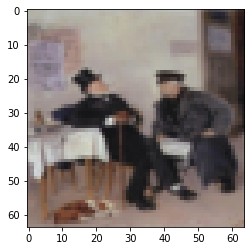

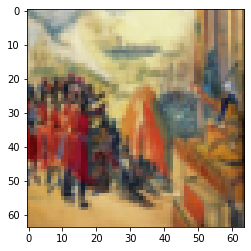

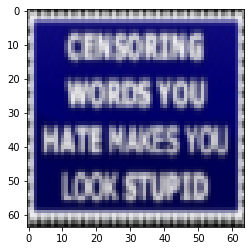

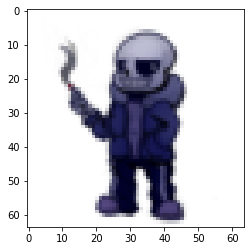

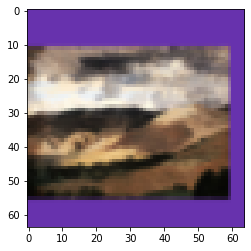

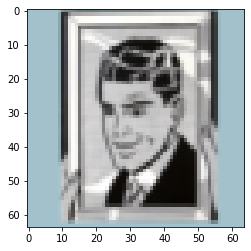

In [134]:
for i, (image, word_vectors_tensor) in enumerate(train_loader):
    print("IMAGE:", image.shape)
    print("WV:", word_vectors_tensor.shape)
    
    for word_vectors in word_vectors_tensor:
        for word_vector in word_vectors:
            wv = np.array(word_vector)
            word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(wv)[0]
            if prob > 0.95:
                print(word, end=',')
        print()
    
    images = np.array(image)
    for img in images:
        img = img.transpose(1, 2, 0)
        plt.imshow(img)
        plt.show()
    break

In [146]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Discriminator

In [147]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(                                                ## 3 x H x W
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),     ## 16 x H/2 x W/2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),    ## 32 x H/4 x W/4
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),    ## 64 x H/8 x W/8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),   ## 128 x H/16 x W/16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),    ## 1 x H/64 x W/64
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [148]:
D = Discriminator().to(DEVICE)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Generator

In [149]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(                                                                
            ## 1 x 2000
            nn.ConvTranspose2d(1 * 2000, 64, kernel_size=4, stride=1, padding=0, bias=False),  
            ## 64 x 4 x 4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            ## 32 x 8 x 8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            ## 16 x 16 x 16
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
            ## 8 x 32 x 32
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1, bias=False),
            ## 3 x 64 x 64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [150]:
G = Generator().to(DEVICE)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(2000, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Loss and optimizers

In [151]:
optimizer_d = torch.optim.Adam(D.parameters(), lr=LR_D, weight_decay=WEIGHT_DECAY)
optimizer_g = torch.optim.Adam(G.parameters(), lr=LR_G, weight_decay=WEIGHT_DECAY)

loss = nn.BCELoss().to(DEVICE)
loss_ls = lambda x, y: 0.5 * torch.mean((x - y) ** 2)
loss_ms = nn.MSELoss().to(DEVICE)

In [152]:
G.train()
D.train()

for epoch in range(N_EPOCHS):

    total_g_loss = 0.0
    total_d_loss = 0.0
    
    for i, (images, word_vectors_tensor) in enumerate(train_loader):

        batch_size = images.size()[0]
        
        real_label = torch.full((batch_size,), 1.0, device=DEVICE)
        fake_label = torch.full((batch_size,), 0.0, device=DEVICE)

        images = images.to(DEVICE)
        word_vectors_tensor = word_vectors_tensor.to(DEVICE)
        word_sequence = word_vectors_tensor[:, 0, :].unsqueeze(2).unsqueeze(3)
        
        # Discriminator pass for real
        D.zero_grad()
        output_real = D(images).view(-1)
        loss_real = loss(output_real, real_label)
        loss_real.backward(retain_graph=False)
        
        # Discriminator pass for fake
        fake = G(word_sequence)
        output_fake = D(fake.detach()).view(-1)
        loss_fake = loss(output_fake, fake_label)
        loss_fake.backward(retain_graph=False)
        loss_d = loss_real + loss_fake
        
        # Discriminator update
        optimizer_d.zero_grad()
        optimizer_d.step()

        # Generator pass
        G.zero_grad()
        output_fake = D(fake).view(-1)
        loss_g = loss(output_fake, real_label)
        loss_g.backward(retain_graph=False)

        # Generator backward pass
        optimizer_g.zero_grad()
        optimizer_g.step()
        
        # Update total loss
        total_g_loss += loss_g.item()
        total_d_loss += loss_d.item()

        # Print logs
        if i % 400 == 0:
            print('[{0:3d}/{1}] {2:3d}/{3} loss_g: {4:.4f} | loss_d: {5:4f}'
                .format(epoch + 1, N_EPOCHS, i + 1, len(train_loader), loss_g.item(), loss_d.item()))
            
    break
            
    
#     # Save your model weights
#     if (epoch + 1) % 5 == 0:
#         save_dict = {
#             'g':G.state_dict(), 
#             'g_optim':optimizer_g.state_dict(),
#             'd': D.state_dict(),
#             'd_optim': optimizer_d.state_dict()
#         }
#         torch.save(save_dict, os.path.join(MODEL_PATH, 'checkpoint_{}.pth'.format(epoch + 1)))
        
#     # Merge noisy input, ground truth and network output so that you can compare your results side by side
#     out = torch.cat([img, fake], dim=2).detach().cpu().clamp(0.0, 1.0)
#     vutils.save_image(out, os.path.join(OUTPUT_PATH, "{}_{}.png".format(epoch, i)), normalize=True)
    
#     # Calculate avarage loss for the current epoch
#     avg_g_loss = total_g_loss / len(data_loader)
#     avg_d_loss = total_d_loss / len(data_loader)
#     print('Epoch[{}] Training Loss G: {:4f} | D: {:4f}'.format(epoch + 1, avg_g_loss, avg_d_loss))
    
#     cache_train_g.append(avg_g_loss)
#     cache_train_d.append(avg_d_loss)

[  1/10]   1/3990 loss_g: 0.5685 | loss_d: 1.485062


/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[  1/10] 401/3990 loss_g: 0.6700 | loss_d: 1.339149


/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (114578698 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[  1/10] 801/3990 loss_g: 0.6931 | loss_d: 1.385615


/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (138720000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (96810200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[  1/10] 1201/3990 loss_g: 0.6931 | loss_d: 1.386294
[  1/10] 1601/3990 loss_g: 0.6931 | loss_d: 1.386294
[  1/10] 2001/3990 loss_g: 0.6931 | loss_d: 1.386294


/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (104770306 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


[  1/10] 2401/3990 loss_g: 0.6931 | loss_d: 1.386294
[  1/10] 2801/3990 loss_g: 0.6931 | loss_d: 1.386294


/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


OSError: Traceback (most recent call last):
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/ImageFile.py", line 235, in load
    s = read(self.decodermaxblock)
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 659, in load_read
    cid, pos, length = self.png.read()
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/PngImagePlugin.py", line 122, in read
    length = i32(s)
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/_binary.py", line 82, in i32be
    return unpack_from(">I", c, o)[0]
struct.error: unpack_from requires a buffer of at least 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 99, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "../lib/dataset.py", line 79, in __getitem__
    img = self.load(image_file)
  File "../lib/dataset.py", line 71, in load
    img = img.convert('RGB')
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/Image.py", line 930, in convert
    self.load()
  File "/home/azmi/miniconda3/envs/pytorch1.3/lib/python3.7/site-packages/PIL/ImageFile.py", line 241, in load
    raise IOError("image file is truncated")
OSError: image file is truncated
